In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, Conv2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import numpy as np
from keras import backend
from keras.constraints import Constraint

In [ ]:
def wasserstein_loss(y_actual,y_pred):
  return backend.mean(y_actual*y_pred)

In [ ]:
class Clipping(Constraint):
  def __init__(self,value):
    self.clip_value=value
  
  def __call__(self,weights):
    return backend.clip(weights,-self.clip_value,self.clip_value)
  
  def get_config(self):
    return {'clip_value':self.clip_value}

In [ ]:
#defining input image dimensions
rows=120
cols=160
channels=3
img_shape = (rows,cols,channels)

In [ ]:
#building a generator
def build_generator():
  noise_shape = (100,) #1D latent vector of size 100 - Input to generator
  #building the model
  model=Sequential()
  model.add(Dense(30*40*128,input_shape=noise_shape))
  model.add(Reshape((30,40,128)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(3,(3,3),strides=(2,2),padding='same',activation='tanh'))

  model.summary()

  noise=Input(shape=noise_shape)
  img=model(noise) #Generated image

  return Model(noise,img)

In [ ]:
#building a discriminator
def build_discriminator():
  const=Clipping(0.01)
  model=Sequential()
  model.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',kernel_constraint=const,input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),kernel_constraint=const,padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dense(100))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1))
  model.summary()

  img=Input(shape=img_shape)
  validity=model(img)

  return Model(img,validity)

In [ ]:
disc_loss=[]

In [ ]:
gen_loss=[]

In [ ]:
def train(epochs,batch_size,save_interval):
  #loading dataset
  X_train=pickle.load(open('drive/MyDrive/Pickles/imdata_ISL.pkl','rb'))
  #rescaling the images
  X_train = (X_train.astype(np.float32)-127.5)/127.5

  n_disc=5
  global d_loss
  #d_loss_i=[]
  for epoch in range(epochs+1):
    '''
    train discriminator
    '''
    d_loss_i=[]
    for step in range(n_disc):
      #select random batch of real images
      id=np.random.randint(0,X_train.shape[0],batch_size)
      imgs=X_train[id]
      #generate batch of fake images
      noise=np.random.normal(0,1,(batch_size,100))
      gen_imgs=generator.predict(noise)
      #discriminator loss
      d_loss_real=discriminator.train_on_batch(imgs,np.ones((batch_size,1)))
      d_loss_fake=discriminator.train_on_batch(gen_imgs,-np.ones((batch_size,1)))
      d_loss=0.5*np.add(d_loss_real,d_loss_fake)
      d_loss_i.append(d_loss)
      
    disc_loss.append(np.mean(d_loss_i))
    '''
    train generator
    '''
    noise=np.random.normal(0,1,(batch_size,100))
    valid_y=np.array([1.0]*batch_size)
    #generator loss
    g_loss=combined.train_on_batch(noise,valid_y)
    gen_loss.append(g_loss)

    print(epoch,' ',np.mean(d_loss_i),' ',g_loss)

    #saving images
    if epoch%save_interval==0:
      save_imgs(epoch)

In [ ]:
def save_imgs(epoch):
  r,c=5,5
  noise=np.random.normal(0,1,(r*c,100))
  gen_imgs=generator.predict(noise)
  #rescale images 0-1
  gen_imgs=0.5*gen_imgs+0.5
  
  fig,axs=plt.subplots(r,c)
  cnt=0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt,:,:,:])
      axs[i,j].axis('off')
      cnt+=1
  fig.savefig("drive/MyDrive/WGAN_images_ISL/ISL%d.png"%epoch)
  #generator.save('drive/MyDrive/WGAN_models_ISL/wgenerator_model_test_ISL%d.h5'%epoch)
  plt.close()

In [ ]:
#choosing the optimizer
optimizer=RMSprop(lr=0.00005)

#building the discriminator
discriminator=build_discriminator()
discriminator.compile(loss=wasserstein_loss,optimizer=optimizer)

#building the generator
generator=build_generator()

#input vector
z=Input(shape=(100,))
img=generator(z)

discriminator.trainable=False

#validity from discriminator
valid=discriminator(img)

#building combined modeel
combined=Model(z,valid)
combined.compile(loss=wasserstein_loss,optimizer=optimizer)

#training the GAN
train(epochs=10000,batch_size=16,save_interval=500)

#saving the generator
generator.save('drive/MyDrive/wgenerator_model_test_ISL.h5')


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
5002   0.5566009521484375   -404.9331970214844
5003   0.8333465576171875   -404.5777587890625
5004   0.4505859375   -403.01104736328125
5005   0.1167572021484375   -404.20745849609375
5006   0.8958526611328125   -403.58685302734375
5007   0.617431640625   -404.19317626953125
5008   0.749176025390625   -402.34014892578125
5009   0.178265380859375   -402.3291931152344
5010   1.156610107421875   -403.5430603027344
5011   0.4526397705078125   -402.996337890625
5012   0.68021240234375   -403.4306945800781
5013   0.2972381591796875   -402.86083984375
5014   0.9092041015625   -403.94207763671875
5015   1.1069488525390625   -403.529541015625
5016   1.0319000244140626   -403.15069580078125
5017   0.866534423828125   -404.11572265625
5018   0.8860260009765625   -403.947509765625
5019   0.7000213623046875   -403.2954406738281
5020   0.1652740478515625   -402.552978515625
5021   0.634625244140625   -403.5217590332031
5022   -0.0490478515625   -402

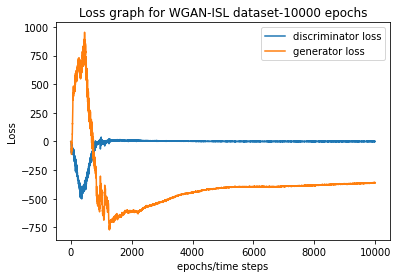

In [ ]:
import matplotlib.pyplot as plt
plt.plot(disc_loss,label='discriminator loss')
plt.plot(gen_loss,label='generator loss')
plt.xlabel('epochs/time steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for WGAN-ISL dataset-10000 epochs')
plt.show()

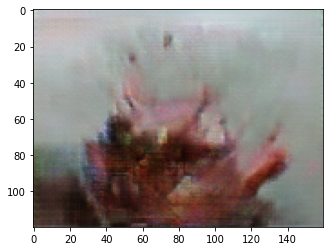

In [ ]:
#Generating random image
from numpy.random import randn
gm=load_model('drive/MyDrive/wgenerator_model_test_ISL.h5')
vector=randn(100)
vector=vector.reshape(1,100)
image=gm.predict(vector)
image=image*0.5+0.5
plt.imshow(image[0,:,:,:])